In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import Libraries and Download NLTK Data
"""
Import necessary libraries and download NLTK data for text preprocessing.
"""
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from google.colab import drive
from collections import Counter

In [3]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
#Download GloVe Embeddings
"""
Download and unzip GloVe embeddings (100d) for the LSTM model.
"""
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-14 06:33:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-14 06:33:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-14 06:33:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
# Define Dataset Path
"""
Specify the dataset path. Update to the assigned dataset.
"""
DATASET_PATH = "/content/drive/MyDrive/AI&ML --- Level 6 /Assignment Folder/spamvsham.csv"

In [6]:
# Load Dataset
"""
Load the dataset using Pandas and prepare labels.
"""
def load_dataset():
    try:
        df = pd.read_csv(DATASET_PATH, encoding='latin-1')
        df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
        print("Dataset Head:\n\n", df.head())
        print("\n")
        print("Dataset Shape:", df.shape)
        return df
    except FileNotFoundError:
        print(f"Error: Dataset '{DATASET_PATH}' not found.")
        return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

df = load_dataset()
if df is None:
    raise SystemExit("Cannot proceed without a valid dataset.")

Dataset Head:

    label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


Dataset Shape: (5572, 2)


In [7]:
# Text Preprocessing
"""
Clean text: lowercase, remove URLs/mentions/hashtags/numbers/special characters,
handle contractions, remove stopwords, and lemmatize.
"""
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    contractions = {"don't": "do not", "won't": "will not", "can't": "cannot"}
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'@\w+|#\w+|\d+|[^\w\s]', '', text)  # Mentions, hashtags, numbers, special chars
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

In [8]:
# Visualize Cleaned Data
"""
Visualize cleaned text with a word cloud and top 10 word frequency plot.
"""
def visualize_cleaned_data(texts):
    # Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Cleaned Text')
    plt.show()

    # Top 10 Words
    word_freq = Counter(' '.join(texts).split()).most_common(10)
    words, counts = zip(*word_freq)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

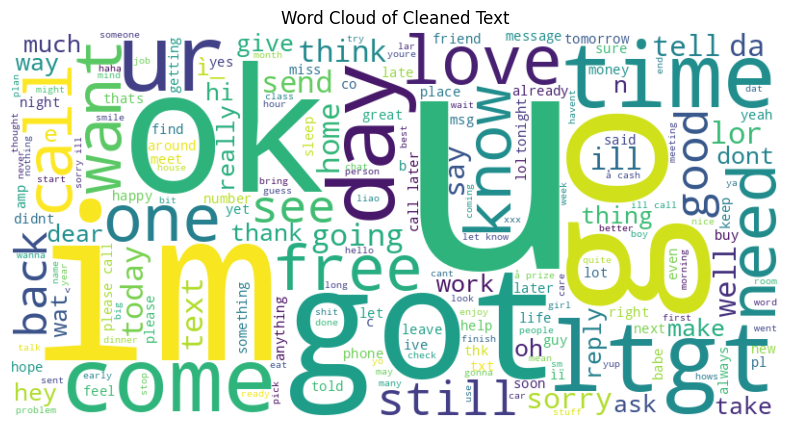

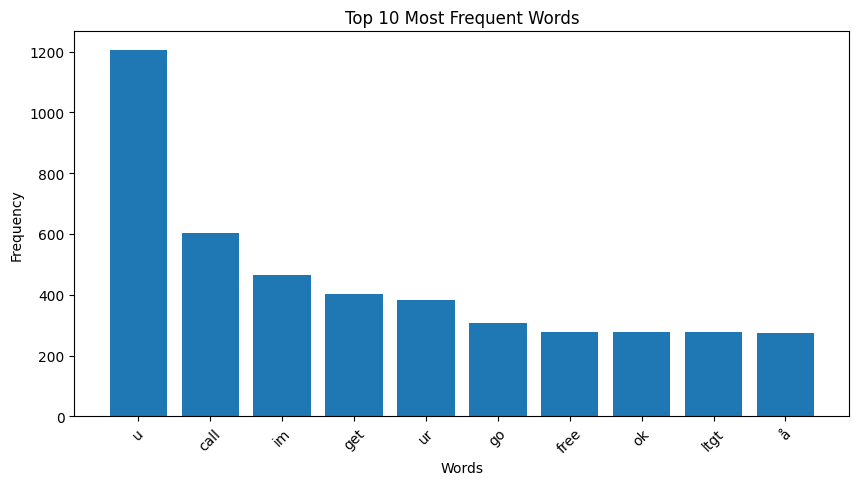

Max Sequence Length: 20


In [9]:
# Tokenization and Padding
"""
Tokenize text, split data (80% train, 20% test), and pad sequences.
"""
def preprocess_and_tokenize(df):
    df['cleaned_text'] = df['text'].apply(clean_text)
    visualize_cleaned_data(df['cleaned_text'])
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_text'], df['label'], test_size=0.2, random_state=42
    )
    global tokenizer, maxlen
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    sequence_lengths = [len(seq) for seq in X_train_seq]
    maxlen = int(np.percentile(sequence_lengths, 95))
    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
    X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)
    print(f"Max Sequence Length: {maxlen}")
    return X_train_pad, X_test_pad, y_train, y_test

X_train_pad, X_test_pad, y_train, y_test = preprocess_and_tokenize(df)

# 3.2 Model Building and Training


In [10]:
#Load GloVe Embeddings
"""
Load GloVe embeddings and create an embedding matrix.
"""
def load_glove_embeddings():
    embeddings_index = {}
    try:
        with open('glove.6B.100d.txt', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except FileNotFoundError:
        print("Error: GloVe file not found.")
        return None, None, None
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = 100
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size, embedding_dim

embedding_matrix, vocab_size, embedding_dim = load_glove_embeddings()
if embedding_matrix is None:
    raise SystemExit("Cannot proceed without GloVe embeddings.")

In [11]:
# Build Simple RNN Model
"""
Build Simple RNN model with trainable Embedding layer.
"""
def build_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, maxlen))
    model.summary()
    return model

model_rnn = build_simple_rnn()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 100)        │       697,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,825 (2.70 MB)

 Trainable params: 707,825 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Build LSTM Model
"""
Build LSTM model with trainable Embedding layer.
"""
def build_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, maxlen))
    model.summary()
    return model

model_lstm = build_lstm()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 100)        │       697,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,505 (2.82 MB)

 Trainable params: 739,505 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Build LSTM with GloVe
"""
Build LSTM model with pretrained GloVe embeddings.
"""
def build_lstm_glove():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, maxlen))
    model.summary()
    return model

model_lstm_glove = build_lstm_glove()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 20, 100)        │       697,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,505 (2.82 MB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 697,200 (2.66 MB)

In [14]:
# Train Models
"""
Train all models with early stopping and save them as .h5 files.
"""
def train_model(model, model_name, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    model.save(f'{model_name}.h5')
    print(f"Saved {model_name}.h5")
    return history

history_rnn = train_model(model_rnn, "Simple_RNN", X_train_pad, y_train)
history_lstm = train_model(model_lstm, "LSTM", X_train_pad, y_train)
history_lstm_glove = train_model(model_lstm_glove, "LSTM_GloVe", X_train_pad, y_train)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8667 - loss: 0.2773 - val_accuracy: 0.9641 - val_loss: 0.1023
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9867 - loss: 0.0462 - val_accuracy: 0.9742 - val_loss: 0.0961
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9953 - loss: 0.0237 - val_accuracy: 0.9709 - val_loss: 0.0953
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9960 - loss: 0.0144 - val_accuracy: 0.9720 - val_loss: 0.0958
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9982 - loss: 0.0119 - val_accuracy: 0.9664 - val_loss: 0.1056
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9974 - loss: 0.0153 - val_accuracy: 0.9619 - val_loss: 0.1829


Saved Simple_RNN.h5
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8661 - loss: 0.3262 - val_accuracy: 0.9753 - val_loss: 0.0869
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9913 - loss: 0.0404 - val_accuracy: 0.9765 - val_loss: 0.0706
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9975 - loss: 0.0145 - val_accuracy: 0.9641 - val_loss: 0.1560
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 0.9787 - val_loss: 0.0869
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9988 - loss: 0.0079 - val_accuracy: 0.9641 - val_loss: 0.1644


Saved LSTM.h5
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8739 - loss: 0.3754 - val_accuracy: 0.9552 - val_loss: 0.1392
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9619 - loss: 0.0984 - val_accuracy: 0.9641 - val_loss: 0.1182
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9785 - loss: 0.0869 - val_accuracy: 0.9596 - val_loss: 0.1268
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9763 - loss: 0.0644 - val_accuracy: 0.9731 - val_loss: 0.1045
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9845 - loss: 0.0520 - val_accuracy: 0.9753 - val_loss: 0.0909
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9907 - loss: 0.0400 - val_accuracy: 0.9753 - val_loss: 0.0936
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9931 - loss: 0.0303 - val_accuracy: 0.9765 - val_loss: 0.0963
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9936 - loss: 0.0

Saved LSTM_GloVe.h5


#3.3 Model Training and Evaluation

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Simple_RNN Evaluation:
Accuracy: 0.9721973094170404
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.97      0.82      0.89       150

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



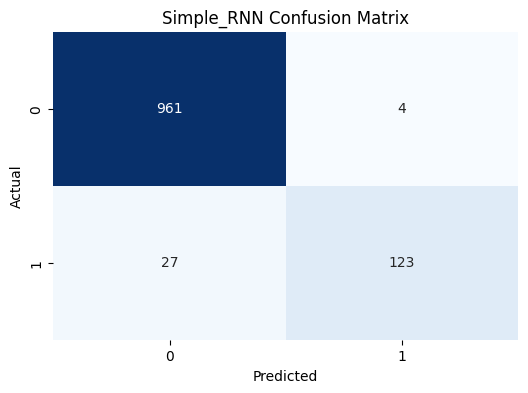

In [15]:
# Evaluate Simple RNN
"""
Evaluate Simple RNN: accuracy, confusion matrix, classification report.
"""
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(model_rnn, "Simple_RNN", X_test_pad, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

LSTM Evaluation:
Accuracy: 0.9856502242152466
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.99      0.91      0.94       150

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



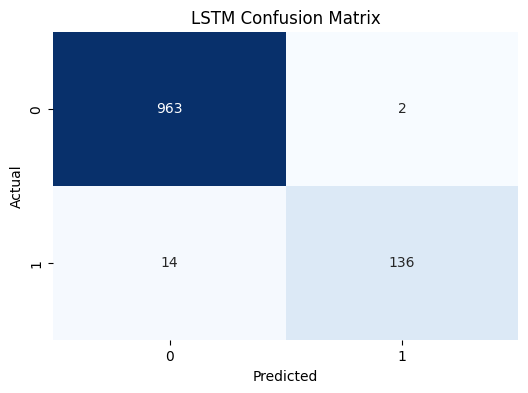

In [16]:
# Evaluate LSTM
"""
Evaluate LSTM: accuracy, confusion matrix, classification report.
"""
evaluate_model(model_lstm, "LSTM", X_test_pad, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

LSTM_GloVe Evaluation:
Accuracy: 0.9730941704035875
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       965
           1       0.95      0.84      0.89       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



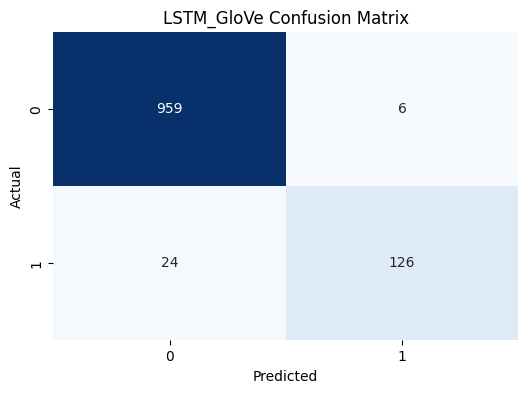

In [17]:
# Evaluate LSTM with GloVe
"""
Evaluate LSTM with GloVe: accuracy, confusion matrix, classification report.
"""
evaluate_model(model_lstm_glove, "LSTM_GloVe", X_test_pad, y_test)

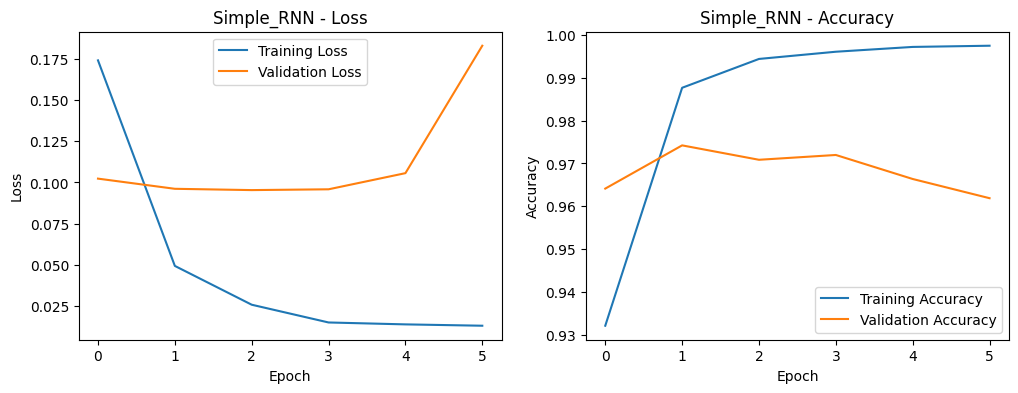

In [18]:
# Visualize Simple RNN Performance
"""
Plot training and validation loss/accuracy for Simple RNN.
"""
def plot_performance(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_performance(history_rnn, "Simple_RNN")

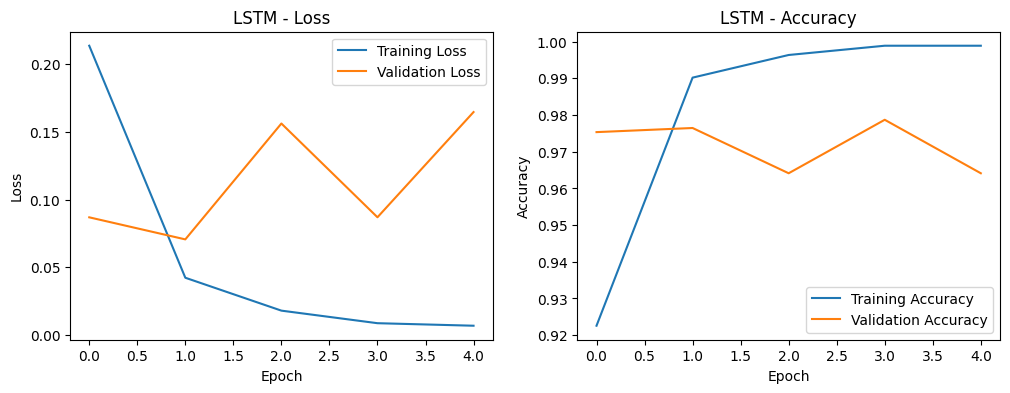

In [19]:
# Visualize LSTM Performance
"""
Plot training and validation loss/accuracy for LSTM.
"""
plot_performance(history_lstm, "LSTM")

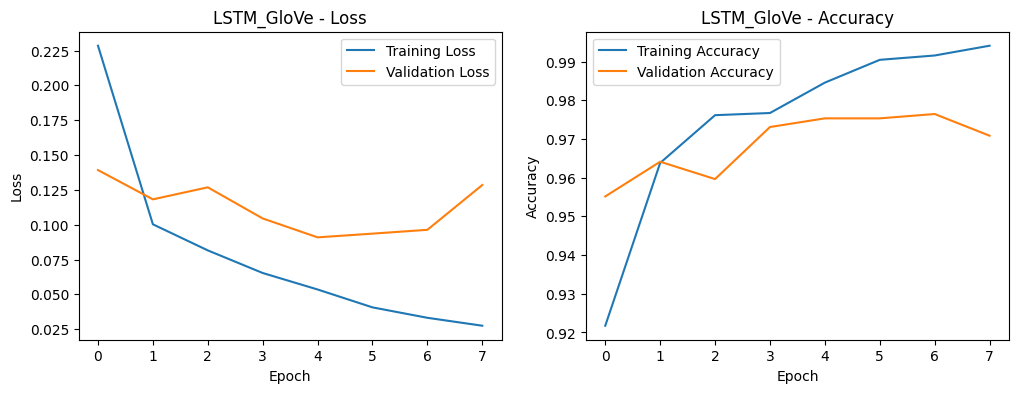

In [20]:
# Visualize LSTM with GloVe Performance
"""
Plot training and validation loss/accuracy for LSTM with GloVe.
"""
plot_performance(history_lstm_glove, "LSTM_GloVe")


Model Comparison - Validation Accuracies:
Simple RNN: 0.9619
LSTM: 0.9641
LSTM with GloVe: 0.9709


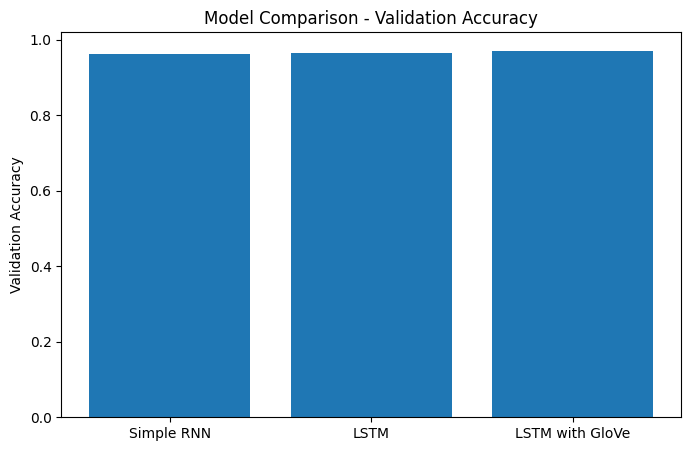

In [21]:
# Compare Models
"""
Compare validation accuracies of all models (text and bar plot).
"""
def compare_models():
    models = ['Simple RNN', 'LSTM', 'LSTM with GloVe']
    accuracies = [
        history_rnn.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        history_lstm_glove.history['val_accuracy'][-1]
    ]
    print("\nModel Comparison - Validation Accuracies:")
    for model, acc in zip(models, accuracies):
        print(f"{model}: {acc:.4f}")
    plt.figure(figsize=(8, 5))
    plt.bar(models, accuracies)
    plt.title('Model Comparison - Validation Accuracy')
    plt.ylabel('Validation Accuracy')
    plt.show()

compare_models()

In [22]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00


#3.4 GUI for Real-Time Prediction

In [23]:
import gradio as gr

def predict_spam(message):
    """
    Predict if a message is spam using the pre-trained LSTM with GloVe model.
    """
    model_path = '/content/LSTM_GloVe.h5'
    try:
        pretrained_model = load_model(model_path)
    except Exception as e:
        return f"Error loading model: {e}"
    msg_clean = clean_text(message)
    msg_seq = tokenizer.texts_to_sequences([msg_clean])
    msg_pad = pad_sequences(msg_seq, padding='post', maxlen=maxlen)
    prediction = pretrained_model.predict(msg_pad)[0][0]
    return ("Spam", prediction) if prediction >= 0.5 else ("Not Spam", prediction)

# Modern CSS styling
css = """
.gradio-container {
    font-family: 'Inter', sans-serif;
    max-width: 600px;
    margin: auto;
}
.header {
    text-align: center;
    margin-bottom: 20px;
}
.header h1 {
    font-size: 28px;
    font-weight: 600;
    color: #2563eb;
    margin-bottom: 8px;
}
.input-box {
    min-height: 120px;
    border-radius: 8px !important;
    padding: 12px !important;
}
.submit-btn {
    background: #2563eb !important;
    color: white !important;
    border-radius: 8px !important;
}
.clear-btn {
    border-radius: 8px !important;
}
.output-box {
    padding: 20px;
    border-radius: 8px;
    margin-top: 20px;
    font-size: 18px;
    font-weight: 500;
    text-align: center;
}
.spam {
    background-color: #fee2e2 !important;
    color: #b91c1c !important;
    border: 1px solid #fca5a5 !important;
}
.not-spam {
    background-color: #dcfce7 !important;
    color: #166534 !important;
    border: 1px solid #86efac !important;
}
.probability {
    font-size: 14px;
    margin-top: 8px;
    opacity: 0.8;
}
"""

with gr.Blocks(css=css) as demo:
    with gr.Column():
        # Header
        gr.Markdown("""
        <div class="header">
            <h1>📱 SMS Spam Detector</h1>
            <p>Detect spam messages with AI</p>
        </div>
        """)

        # Input
        msg_input = gr.Textbox(
            label="Enter your message",
            placeholder="Paste SMS content here...",
            lines=4,
            elem_classes=["input-box"]
        )

        # Buttons
        with gr.Row():
            submit_btn = gr.Button("Check", elem_classes=["submit-btn"])
            clear_btn = gr.Button("Clear", elem_classes=["clear-btn"])

        # Output
        output = gr.Textbox(
            label="Result",
            interactive=False,
            elem_classes=["output-box"]
        )

        # Probability (hidden by default)
        probability = gr.Markdown(
            elem_classes=["probability"],
            visible=False
        )

    def predict_and_style(message):
        if not message.strip():
            return "", gr.Markdown(visible=False)

        result, prob = predict_spam(message)
        prob_percent = f"{prob*100:.1f}%"

        if result == "Spam":
            output_style = "spam"
            result_text = f"🚨 SPAM DETECTED ({prob_percent} confidence)"
        else:
            output_style = "not-spam"
            result_text = f"NOT SPAM ({prob_percent} confidence)"

        return (
            gr.Textbox(value=result_text, elem_classes=[output_style]),
            gr.Markdown(value=f"Probability: {prob_percent}", visible=True)
        )

    submit_btn.click(
        fn=predict_and_style,
        inputs=msg_input,
        outputs=[output, probability]
    )

    clear_btn.click(
        fn=lambda: ["", gr.Markdown(visible=False)],
        outputs=[output, probability]
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://facd78e28167c27248.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
